In [1]:
import sys

sys.path.append("../../")

from astronn import datasets
from astronn import models

import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
from scipy.signal import find_peaks, peak_widths


seed_value = 12345
import os

os.environ["PYTHONHASHSEED"] = str(seed_value)
import random
import numpy as np

random.seed(seed_value)
np.random.seed(seed_value)
import tensorflow as tf
tf.autograph.set_verbosity(0)

# Star model to train
star_models = datasets.starmodels()

df_train = star_models.load(
    #"/home/roberto/Downloads/evolutionTracks_line/parts_train/*_norm",
    "/home/roberto/Downloads/evolutionTracks_line/norm8/*_norm",
    batch_size=500,
    add_noise=False,
)
df_validation = star_models.load(
    #"/home/roberto/Downloads/evolutionTracks_line/parts_validation/*_norm",
    "/home/roberto/Downloads/evolutionTracks_line/nomr8_validation/*_norm",
    batch_size=150,
    add_noise=False,
)


# Read datasets of preprocessed real stars to test
df_ds = datasets.deltascuti()
deltascuti = df_ds.load(
    "../../astronn/data/deltascuti/preprocessed/*", batch_size=1
)
bedding_stars = datasets.bedding()
df_bedding = bedding_stars.load("../data/bedding/preprocessed/*", batch_size=1)

# Get stars
ds_stars = [star for star in deltascuti.take(11)]
ds_bedding = [star for star in df_bedding.take(57)]

Using TensorFlow backend.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
"""

# Learn and autoencoder from star models
from tensorflow.keras import layers
from keras.models import load_model

encoding_dim = 2

autoencoder = tf.keras.Sequential(
    [
        layers.Input(shape=(400, 2)),
        layers.Flatten(),
        layers.Dense(200),
        layers.Dense(
            encoding_dim,
            name="lattent",
            activity_regularizer=tf.keras.regularizers.l1(10e-5),
        ),
        layers.Dense(200),
        layers.Dense(800),
        layers.Reshape((400, 2)),
    ]
)

# This model maps an input to its reconstruction
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
autoencoder.compile(loss="binary_crossentropy", optimizer=opt, metrics=["mse"])
autoencoder.summary()

autoencoder.fit(
    df_train, steps_per_epoch=40, epochs=10, verbose=True,
)
"""

'\n\n# Learn and autoencoder from star models\nfrom tensorflow.keras import layers\nfrom keras.models import load_model\n\nencoding_dim = 2\n\nautoencoder = tf.keras.Sequential(\n    [\n        layers.Input(shape=(400, 2)),\n        layers.Flatten(),\n        layers.Dense(200),\n        layers.Dense(\n            encoding_dim,\n            name="lattent",\n            activity_regularizer=tf.keras.regularizers.l1(10e-5),\n        ),\n        layers.Dense(200),\n        layers.Dense(800),\n        layers.Reshape((400, 2)),\n    ]\n)\n\n# This model maps an input to its reconstruction\nopt = tf.keras.optimizers.Adam(learning_rate=0.1)\nautoencoder.compile(loss="binary_crossentropy", optimizer=opt, metrics=["mse"])\nautoencoder.summary()\n\nautoencoder.fit(\n    df_train, steps_per_epoch=40, epochs=10, verbose=True,\n)\n'

In [4]:
"""
count = 0
for star in df_train.take(1):
    plt.plot(star[0][0, :, 0])
    plt.plot(star[0][0, :, 1])
    plt.show()
    
plt.plot(autoencoder.predict(star[0])[0])

autoencoder.get_layer("lattent").output
autoencoder.save("/tmp/autoencoder")
"""

'\ncount = 0\nfor star in df_train.take(1):\n    plt.plot(star[0][0, :, 0])\n    plt.plot(star[0][0, :, 1])\n    plt.show()\n    \nplt.plot(autoencoder.predict(star[0])[0])\n\nautoencoder.get_layer("lattent").output\nautoencoder.save("/tmp/autoencoder")\n'

In [5]:
#model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#    filepath="/tmp/model_checkpoint",
#    save_weights_only=True,
#    monitor='val_acc',
#    mode='max',
#    save_best_only=True)

In [6]:
def get_peak_width(position, peaks, peaks_width, peaks_sorted_by_prob):
    """
    """
    peak_id = np.where(probs == peaks_sorted_by_prob[position])[0][0]
    return (peak_id, peaks_width[0][np.where(peaks == peak_id)[0][0]])

In [7]:
results = {}
results["loss"] = []
results["accuracy"] = []
results["val_loss"] = []
results["val_accuracy"] = []

results["binaries_errors"] = []
results["binaries_errors_top2"] = []
results["binaries_mse"] = []

results["bedding_errors"] = []
results["bedding_errors_top2"] = []
results["bedding_mse"] = []

weighted_array_train = np.array([np.float32(i) for i in range(100)])
class_weight_dict = dict(enumerate(weighted_array_train))

higher_n_probs = 10
loops = 1
for loop in range(loops):
    print("Loop %s" % loop)
    sepconv_mod = models.separableconvnn()  # init model
    sepconv_mod.compile(learning_rate=0.01)  # compile model

    for ep in range(300 + 1):
        print("Episode %s" % ep)
        history = sepconv_mod.model.fit(
            # df_train,
            df_train,
            validation_data=df_validation,
            validation_steps=1,
            steps_per_epoch=10,
            epochs=1,
            verbose=True,
        )

        if ep % 20 == 0:
            sepconv_mod.save("/tmp/sepconvnn_tmp_dos_%s" % ep)  # tmp model save
            
        results["loss"].append(history.history["loss"][0])
        results["accuracy"].append(history.history["accuracy"][0])
        results["val_loss"].append(history.history["val_loss"][0])
        results["val_accuracy"].append(history.history["val_accuracy"][0])

Loop 0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 396, 10)           110       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 392, 20)           1020      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 196, 20)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 10)           410       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 194, 5)            105       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 97, 5)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 97, 5)       

10/10 [==============================] - 3s 244ms/step - loss: 0.0342 - accuracy: 0.2984 - val_loss: 0.0428 - val_accuracy: 0.1400
Episode 26
10/10 [==============================] - 2s 240ms/step - loss: 0.0340 - accuracy: 0.3048 - val_loss: 0.0407 - val_accuracy: 0.2267
Episode 27
10/10 [==============================] - 2s 241ms/step - loss: 0.0346 - accuracy: 0.2908 - val_loss: 0.0408 - val_accuracy: 0.2867
Episode 28
10/10 [==============================] - 2s 240ms/step - loss: 0.0337 - accuracy: 0.3082 - val_loss: 0.0424 - val_accuracy: 0.2067
Episode 29
10/10 [==============================] - 2s 241ms/step - loss: 0.0336 - accuracy: 0.3094 - val_loss: 0.0413 - val_accuracy: 0.2800
Episode 30
10/10 [==============================] - 2s 243ms/step - loss: 0.0335 - accuracy: 0.3112 - val_loss: 0.0381 - val_accuracy: 0.2467
Episode 31
10/10 [==============================] - 2s 241ms/step - loss: 0.0331 - accuracy: 0.3250 - val_loss: 0.0361 - val_accuracy: 0.2800
Episode 32
10/10 

10/10 [==============================] - 2s 243ms/step - loss: 0.0319 - accuracy: 0.3254 - val_loss: 0.7645 - val_accuracy: 0.2400
Episode 70
10/10 [==============================] - 2s 243ms/step - loss: 0.0320 - accuracy: 0.3262 - val_loss: 0.7763 - val_accuracy: 0.2600
Episode 71
10/10 [==============================] - 2s 242ms/step - loss: 0.0317 - accuracy: 0.3270 - val_loss: 0.2818 - val_accuracy: 0.2333
Episode 72
10/10 [==============================] - 2s 243ms/step - loss: 0.0317 - accuracy: 0.3448 - val_loss: 0.2872 - val_accuracy: 0.3067
Episode 73
10/10 [==============================] - 2s 243ms/step - loss: 0.0316 - accuracy: 0.3376 - val_loss: 0.0977 - val_accuracy: 0.3200
Episode 74
10/10 [==============================] - 3s 243ms/step - loss: 0.0316 - accuracy: 0.3332 - val_loss: 0.2568 - val_accuracy: 0.3000
Episode 75
10/10 [==============================] - 2s 238ms/step - loss: 0.0316 - accuracy: 0.3416 - val_loss: 0.1508 - val_accuracy: 0.3267
Episode 76
10/10 

Episode 113
10/10 [==============================] - 2s 242ms/step - loss: 0.0308 - accuracy: 0.3616 - val_loss: 0.0986 - val_accuracy: 0.3133
Episode 114
10/10 [==============================] - 2s 241ms/step - loss: 0.0310 - accuracy: 0.3446 - val_loss: 0.0918 - val_accuracy: 0.3400
Episode 115
10/10 [==============================] - 2s 242ms/step - loss: 0.0309 - accuracy: 0.3484 - val_loss: 0.1237 - val_accuracy: 0.3067
Episode 116
10/10 [==============================] - 2s 241ms/step - loss: 0.0309 - accuracy: 0.3488 - val_loss: 0.0720 - val_accuracy: 0.3133
Episode 117
10/10 [==============================] - 2s 241ms/step - loss: 0.0309 - accuracy: 0.3568 - val_loss: 0.1284 - val_accuracy: 0.3800
Episode 118
10/10 [==============================] - 2s 242ms/step - loss: 0.0310 - accuracy: 0.3470 - val_loss: 0.1264 - val_accuracy: 0.3800
Episode 119
10/10 [==============================] - 3s 244ms/step - loss: 0.0310 - accuracy: 0.3564 - val_loss: 0.0834 - val_accuracy: 0.3133

10/10 [==============================] - 3s 243ms/step - loss: 0.0303 - accuracy: 0.3652 - val_loss: 0.0787 - val_accuracy: 0.4000
Episode 157
10/10 [==============================] - 2s 243ms/step - loss: 0.0303 - accuracy: 0.3714 - val_loss: 0.0869 - val_accuracy: 0.3600
Episode 158
10/10 [==============================] - 2s 242ms/step - loss: 0.0305 - accuracy: 0.3536 - val_loss: 0.0950 - val_accuracy: 0.3667
Episode 159
10/10 [==============================] - 3s 246ms/step - loss: 0.0304 - accuracy: 0.3708 - val_loss: 0.2086 - val_accuracy: 0.3467
Episode 160
10/10 [==============================] - 3s 245ms/step - loss: 0.0306 - accuracy: 0.3582 - val_loss: 0.0893 - val_accuracy: 0.3867
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_co

Episode 200
10/10 [==============================] - 2s 242ms/step - loss: 0.0300 - accuracy: 0.3818 - val_loss: 0.0612 - val_accuracy: 0.4400
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: /tmp/sepconvnn_tmp_dos_200/assets
Episode 201
10/10 [==============================] - 2s 242ms/step - loss: 0.0302 - accuracy: 0.3724 - val_loss: 0.0301 - val_accuracy: 0.3933
Episode 202
10/10 [============

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: /tmp/sepconvnn_tmp_dos_240/assets
Episode 241
10/10 [==============================] - 2s 240ms/step - loss: 0.0298 - accuracy: 0.3706 - val_loss: 0.0283 - val_accuracy: 0.3933
Episode 242
10/10 [==============================] - 2s 242ms/step - loss: 0.0301 - accuracy: 0.3796 - val_loss: 0.0289 - val_accuracy: 0.4067
Episode 243
10/10 [==============================] - 2s 243ms/step - loss: 0.0299 - accuracy: 0.3672 - val_loss: 0.0326 - val_accuracy: 0.3800
Episode 244
10/10 [==============================] - 2s 242ms/step - loss: 0.0301 - accuracy: 0.3720 - val_loss: 0.0298 - val_accuracy: 0.3800
Episode 245
10/10 [=============================

Episode 281
10/10 [==============================] - 2s 241ms/step - loss: 0.0297 - accuracy: 0.3736 - val_loss: 0.0296 - val_accuracy: 0.3800
Episode 282
10/10 [==============================] - 2s 243ms/step - loss: 0.0297 - accuracy: 0.3716 - val_loss: 0.0308 - val_accuracy: 0.3933
Episode 283
10/10 [==============================] - 2s 241ms/step - loss: 0.0297 - accuracy: 0.3706 - val_loss: 0.0309 - val_accuracy: 0.3467
Episode 284
10/10 [==============================] - 2s 241ms/step - loss: 0.0297 - accuracy: 0.3716 - val_loss: 0.0370 - val_accuracy: 0.3933
Episode 285
10/10 [==============================] - 2s 243ms/step - loss: 0.0293 - accuracy: 0.3888 - val_loss: 0.0319 - val_accuracy: 0.3400
Episode 286
10/10 [==============================] - 2s 241ms/step - loss: 0.0294 - accuracy: 0.3748 - val_loss: 0.0271 - val_accuracy: 0.4533
Episode 287
10/10 [==============================] - 3s 243ms/step - loss: 0.0296 - accuracy: 0.3756 - val_loss: 0.0289 - val_accuracy: 0.3667

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
['KIC8262223']


/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


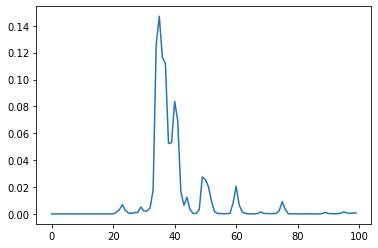

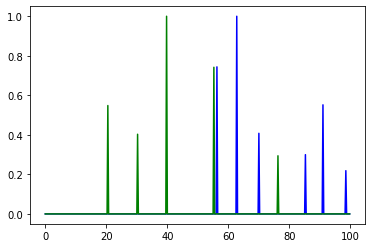

['KIC8262223', 'kic4544587']


/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


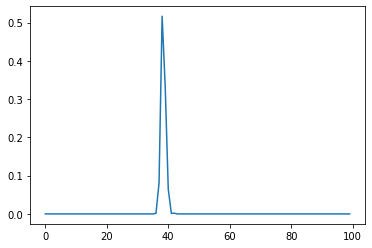

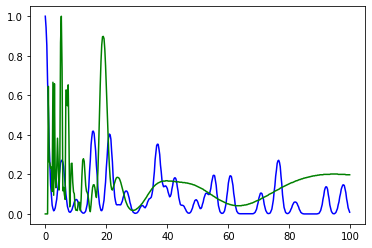

['KIC8262223', 'kic4544587', 'kic10661783']


/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


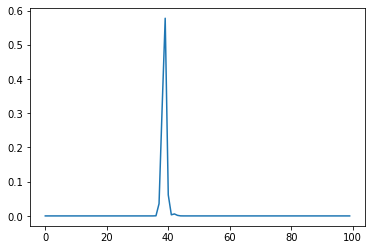

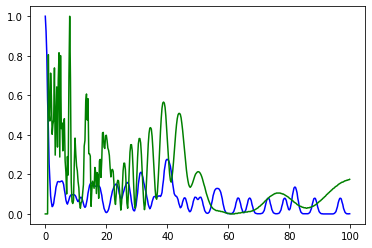

['KIC8262223', 'kic4544587', 'kic10661783', 'kic4544587']


/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


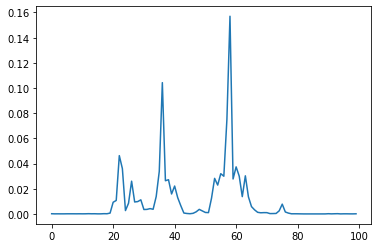

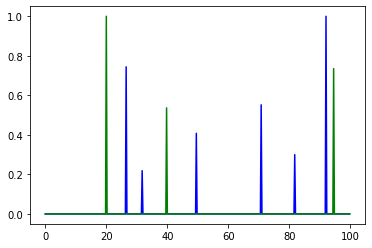

['KIC8262223', 'kic4544587', 'kic10661783', 'kic4544587', 'CID100866999']


/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


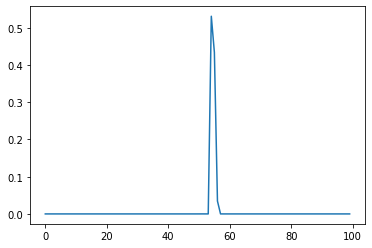

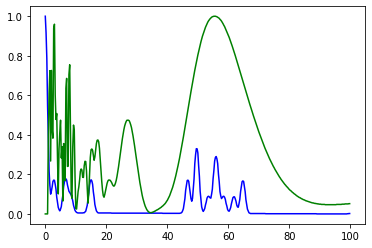

['KIC8262223', 'kic4544587', 'kic10661783', 'kic4544587', 'CID100866999', 'KIC9851944']


/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


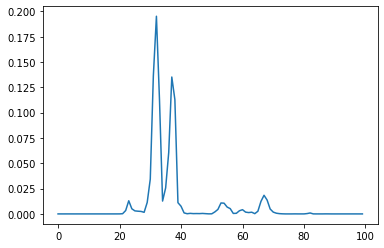

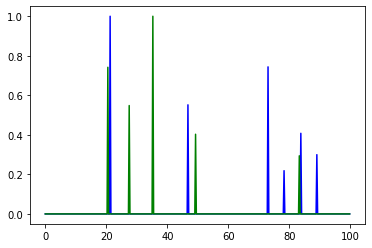

['KIC8262223', 'kic4544587', 'kic10661783', 'kic4544587', 'CID100866999', 'KIC9851944', 'HD15082']


/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


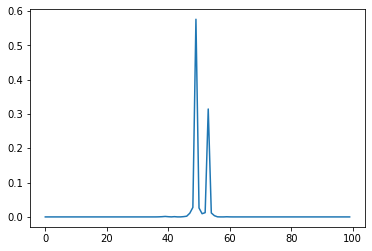

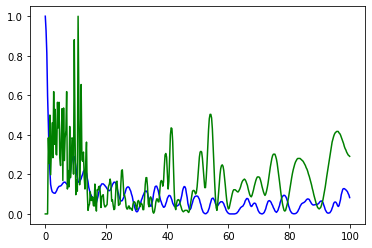

['KIC8262223', 'kic4544587', 'kic10661783', 'kic4544587', 'CID100866999', 'KIC9851944', 'HD15082', 'KIC10080943']


/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


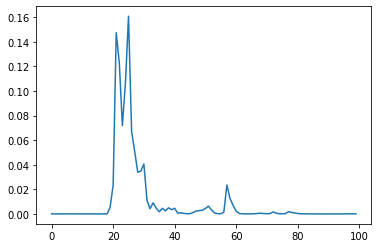

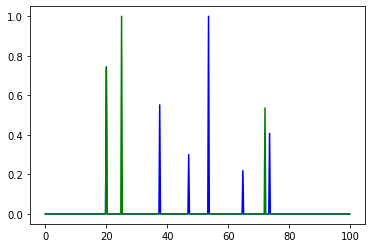

['KIC8262223', 'kic4544587', 'kic10661783', 'kic4544587', 'CID100866999', 'KIC9851944', 'HD15082', 'KIC10080943', 'HD172189']


/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


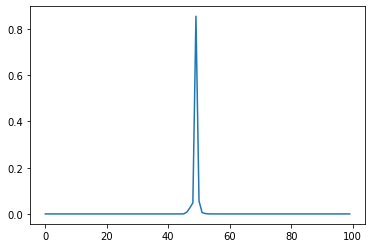

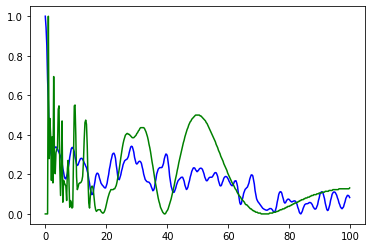

/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


['KIC8262223', 'kic4544587', 'kic10661783', 'kic4544587', 'CID100866999', 'KIC9851944', 'HD15082', 'KIC10080943', 'HD172189', 'CID105906206']


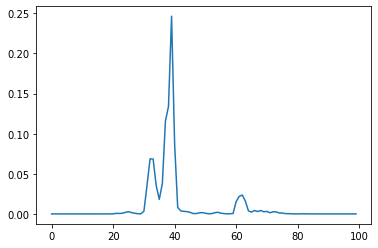

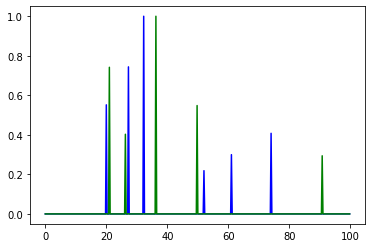

['KIC8262223', 'kic4544587', 'kic10661783', 'kic4544587', 'CID100866999', 'KIC9851944', 'HD15082', 'KIC10080943', 'HD172189', 'CID105906206', 'CID100866999']


/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


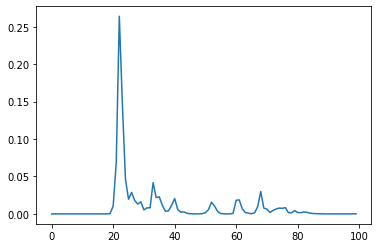

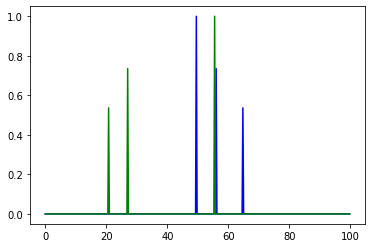

[-42 -36   0 -16  -2   6 -31 -27  30  19 -34]
-12.090909090909092
678.4545454545455
[35, 38, 39, 58, 54, 32, 49, 25, 49, 39, 22]
[77, 74, 39, 74, 56, 26, 80, 52, 19, 20, 56]
['KIC8262223', 'kic4544587', 'kic10661783', 'kic4544587', 'CID100866999', 'KIC9851944', 'HD15082', 'KIC10080943', 'HD172189', 'CID105906206', 'CID100866999']


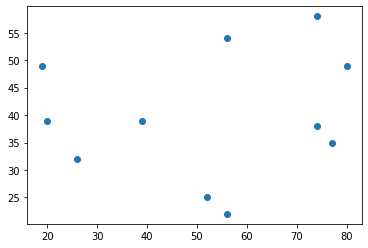

In [8]:
x = []
y = []
l = []
for star in ds_stars:
    target = np.where(star[2].numpy().flat == 1)[0].flat[0]
    l.append(star[0].numpy()[0].decode("utf-8"))
    probs = sepconv_mod.model.predict_proba(star[1])[0]

    print(l)
    plt.plot(probs)
    plt.show()

    plt.plot(np.arange(0, 100, 0.25), star[1][0, :, 0], label="dft", color="blue")
    # plt.plot(x, star[1][0, :, 1], label="hod", color="orange", alpha=0.5)
    plt.plot(np.arange(0, 100, 0.25), star[1][0, :, 1], label="ac", color="green")
    plt.show()
    peaks, _ = find_peaks(probs, height=0, distance=5)
    peaks_width = peak_widths(probs, peaks)
    peaks_sorted_by_prob = np.sort(probs[peaks])[::-1]
    best_peak, best_peak_width = get_peak_width(
        0, peaks, peaks_width, peaks_sorted_by_prob
    )
    x.append(best_peak)
    y.append(target)

plt.scatter(y, x, label=l)
print(np.asarray(x) - np.asarray(y))
print(np.mean(np.asarray(x) - np.asarray(y)))
print(np.mean(np.power(np.asarray(x) - np.asarray(y), 2)))
print(x)
print(y)
print(l)

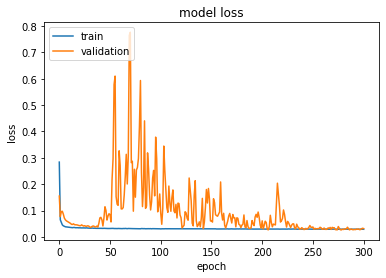

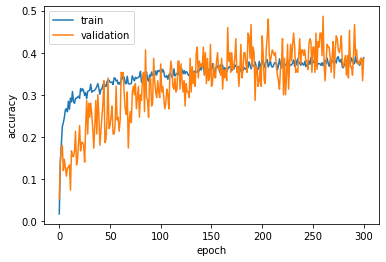

In [9]:
plt.plot(results["loss"])
plt.plot(results["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

plt.plot(results["accuracy"])
plt.plot(results["val_accuracy"])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [10]:
x = [i for i in range(len(results["binaries_errors"]))]
y = results["binaries_errors"]
m, b = np.polyfit(x, y, 1)
plt.plot(x, m * np.asarray(x) + b)

TypeError: expected non-empty vector for x

In [ ]:
x = [i for i in range(len(results["bedding_errors"]))]
y = results["bedding_errors"]
m, b = np.polyfit(x, y, 1)
plt.plot(x, m * np.asarray(x) + b)

In [ ]:
targets = {}
targets["kic10661783"] = {"dnu": 39.0, "dr": 7.0}
targets["KIC9851944"] = {"dnu": 26.0, "dr": 5.3}
targets["HD159561"] = {"dnu": 38.0, "dr": 19.0}
targets["CID100866999"] = {"dnu": 56, "dr": np.nan}
targets["HD15082"] = {"dnu": 80.0, "dr": 14.0}
targets["kic4544587"] = {"dnu": 74.0, "dr": 11.0}
targets["KIC8262223"] = {"dnu": 77.0, "dr": 7.10}
targets["HD172189"] = {"dnu": 19.0, "dr": 4.6}
targets["KIC3858884"] = {"dnu": 19.0, "dr": 1.9}
targets["CID105906206"] = {"dnu": 20.0, "dr": 2.61}
targets["KIC10080943"] = {"dnu": 52.0, "dr": 1.7}

import matplotlib.cm as cm
import matplotlib.colors as mcolors

# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=0, vmax=higher_n_probs)
colormap = plt.get_cmap("jet_r")
# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(higher_n_probs)

for star in results.keys():
    if star in targets.keys():
        for idx, val in enumerate(range(higher_n_probs)):
            plt.plot(
                results[star][(val,)],
                alpha=0.5,
                marker="o",
                linestyle="None",
                color=colormap(normalize(idx)),
                markersize=higher_n_probs - idx,
            )
        plt.xlabel("NN epoch traininng (class infered)")
        plt.ylabel(r"Frequency ($\mu$hz)")
        plt.axhline(y=targets[star]["dnu"], color="black")
        plt.title(star)
        plt.ylim(0, 100)
        cbar = plt.colorbar(scalarmappaple)
        cbar.set_label("Inference order (by probability)")
        plt.show()